In [1]:
import cv2 as cv 
import numpy as np 
import os
import matplotlib.pyplot as plt
import math
import random


In [2]:
# Dence Optical View
cap = cv.VideoCapture("Video.mp4")
ret, frame1 = cap.read()
gray_prev = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)

mask = np.zeros_like(frame1)

# set image saturation to maximum
mask[..., 1] = 255

frames = []

while cap.isOpened():
    ret, frame2 = cap.read()
    if not ret:
        break
    gray_next = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)

    flow = cv.calcOpticalFlowFarneback(
        gray_prev,
        gray_next,
        None,             # Initial flow
        pyr_scale=0.4,    # Scale to capture motions
        levels=4,         # More pyramid levels for better motion capture
        winsize=21,       # Larger window to average over larger areas
        iterations=5,     # More iterations for accurate flow estimation
        poly_n=7,         # Larger neighborhood for polynomial expansion
        poly_sigma=1.5,   # Slightly higher sigma for smoother flow
        flags=0           # No flags
    )
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
    mask[..., 0] = angle * 180 / np.pi / 2
    mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)

    rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
    frames.append(rgb)
    cv.imshow("Dense Optical Flow", rgb)

    gray_prev = gray_next

    if cv.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

# Write frames to video file
if len(frames) > 0:
    height, width = frames[0].shape[:2]
    out = cv.VideoWriter('output.avi', cv.VideoWriter_fourcc(*'XVID'), 20.0, (width, height))
    for frame in frames:
        out.write(frame)
    out.release()


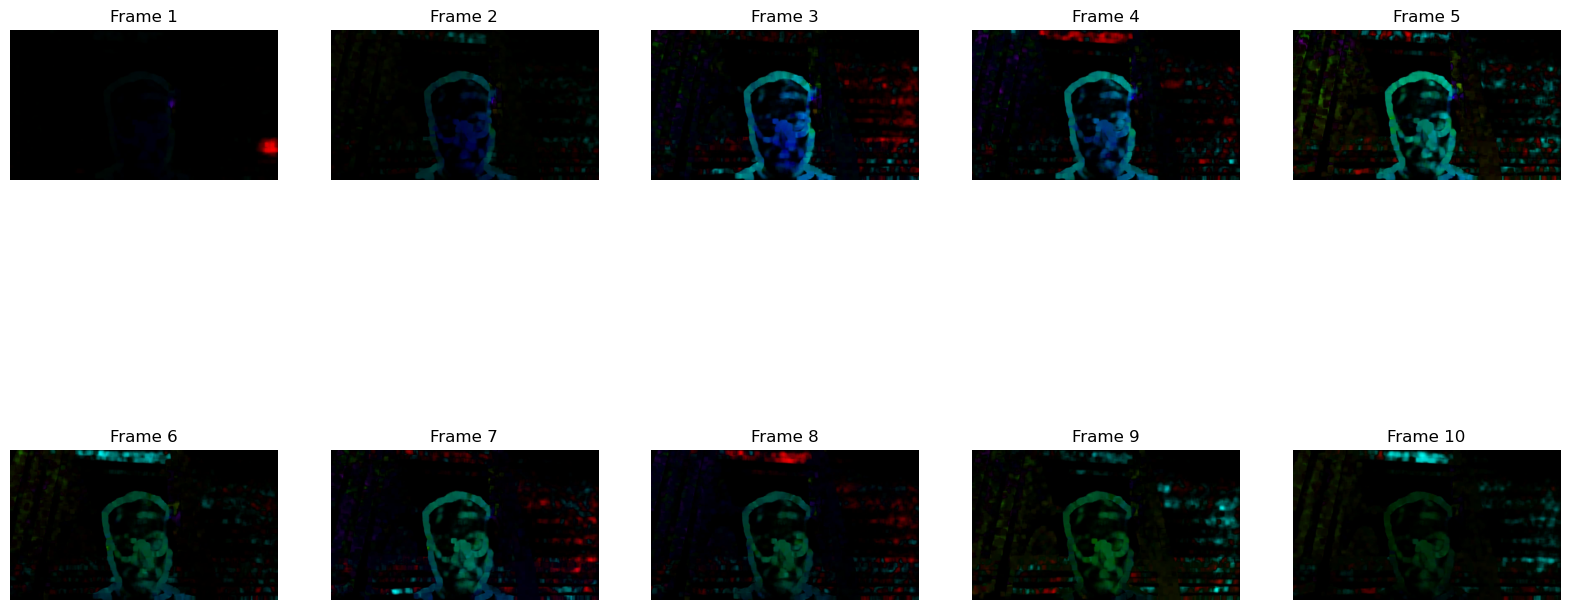

In [3]:
# Load output.avi and display some frames
frames = []
cap = cv.VideoCapture("output.avi")
for i in range(10):
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

cap.release()

# Display frames
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i, frame in enumerate(frames):
    ax = axs[i // 5, i % 5]
    ax.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
    ax.axis("off")
    ax.set_title(f"Frame {i + 1}")



In [4]:
def sparse_optical_flow(video_path):
    # Open the video file
    cap = cv.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Read the first frame
    ret, prev_frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        return

    # Convert the first frame to grayscale
    prev_gray = cv.cvtColor(prev_frame, cv.COLOR_BGR2GRAY)

    prev_points = cv.goodFeaturesToTrack(prev_gray, mask=None, maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(prev_frame)

    frames = []  # List to store output frames

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the current frame to grayscale
        curr_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        next_points, status, error = cv.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_points, None)

        # Select good points: status = 1 means the point was successfully tracked
        good_new = next_points[status == 1]
        good_old = prev_points[status == 1]

        # Draw the flow (lines and circles)
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
            frame = cv.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)

        # Overlay the mask on the current frame
        output = cv.add(frame, mask)

        # Store the frame
        frames.append(output)

        # Display the frame with the tracked points and flow
        cv.imshow('Sparse Optical Flow (Lucas-Kanade)', output)

        # Update previous frame and points for next iteration
        prev_gray = curr_gray.copy()
        prev_points = good_new.reshape(-1, 1, 2)

        # Exit on pressing 'q'
        if cv.waitKey(10) & 0xFF == ord('q'):
            break

    # Release resources
    cap.release()
    cv.destroyAllWindows()

    # Write frames to video file
    if len(frames) > 0:
        height, width = frames[0].shape[:2]
        out = cv.VideoWriter('sparse_output.avi', cv.VideoWriter_fourcc(*'XVID'), 20.0, (width, height))
        for frame in frames:
            out.write(frame)
        out.release()

# Example usage
video_path = 'video.mp4'
sparse_optical_flow(video_path)

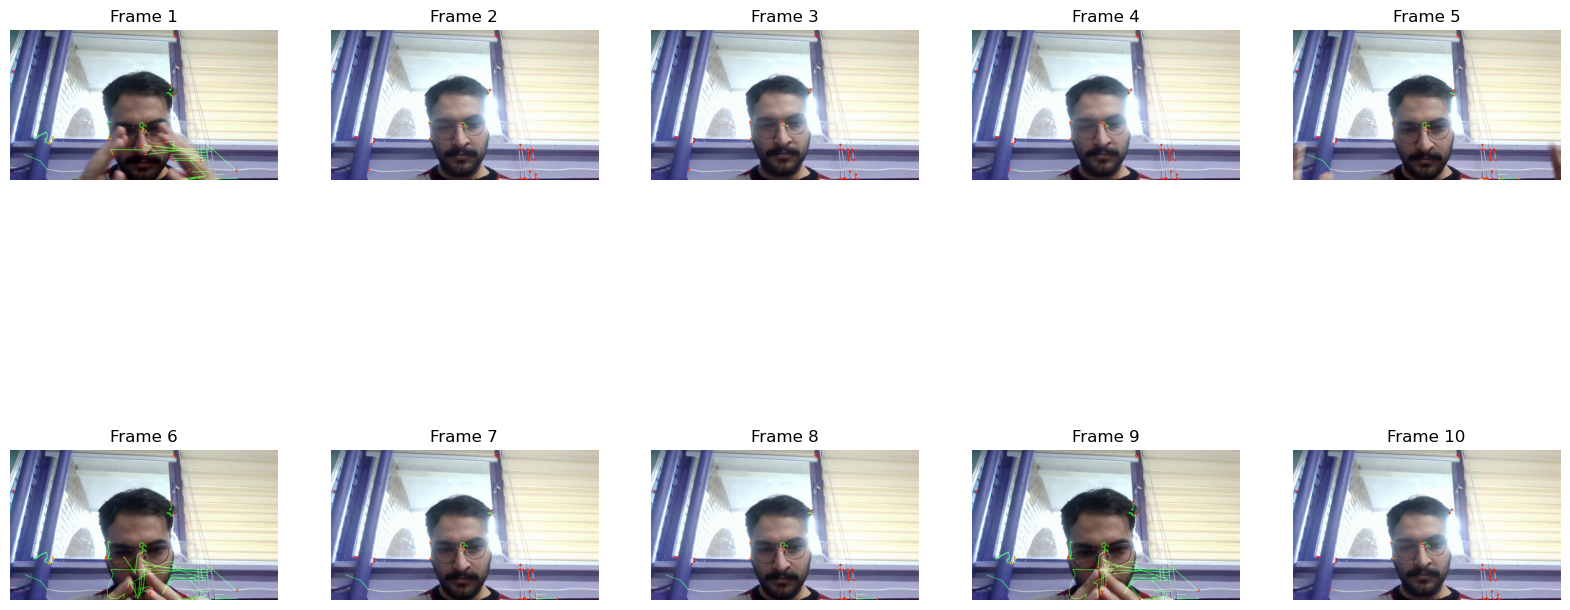

In [6]:
# Load sparse_output.avi and display some frames
frames = []
cap = cv.VideoCapture("sparse_output.avi")
for i in range(100):
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

cap.release()
frames = random.sample(frames, 10)
# Display frames
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i, frame in enumerate(frames):
    ax = axs[i // 5, i % 5]
    ax.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
    ax.axis("off")
    ax.set_title(f"Frame {i + 1}")

In [2]:
def load_images_from_subfolder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            images.append(gray_img)
    return images
    
def load_images_from_folder(folder):
    images = []
    for subfolder in os.listdir(folder):
        images.append(load_images_from_subfolder(os.path.join(folder, subfolder)))
    return images

suprise_images = load_images_from_folder('Data\surprise videos')
happy_images = load_images_from_folder('Data\happy videos')
print(f"Number of surprise videos: {len(suprise_images)}")
print(f"Number of happy videos: {len(happy_images)}")

Number of surprise videos: 30
Number of happy videos: 30


14
list index out of range


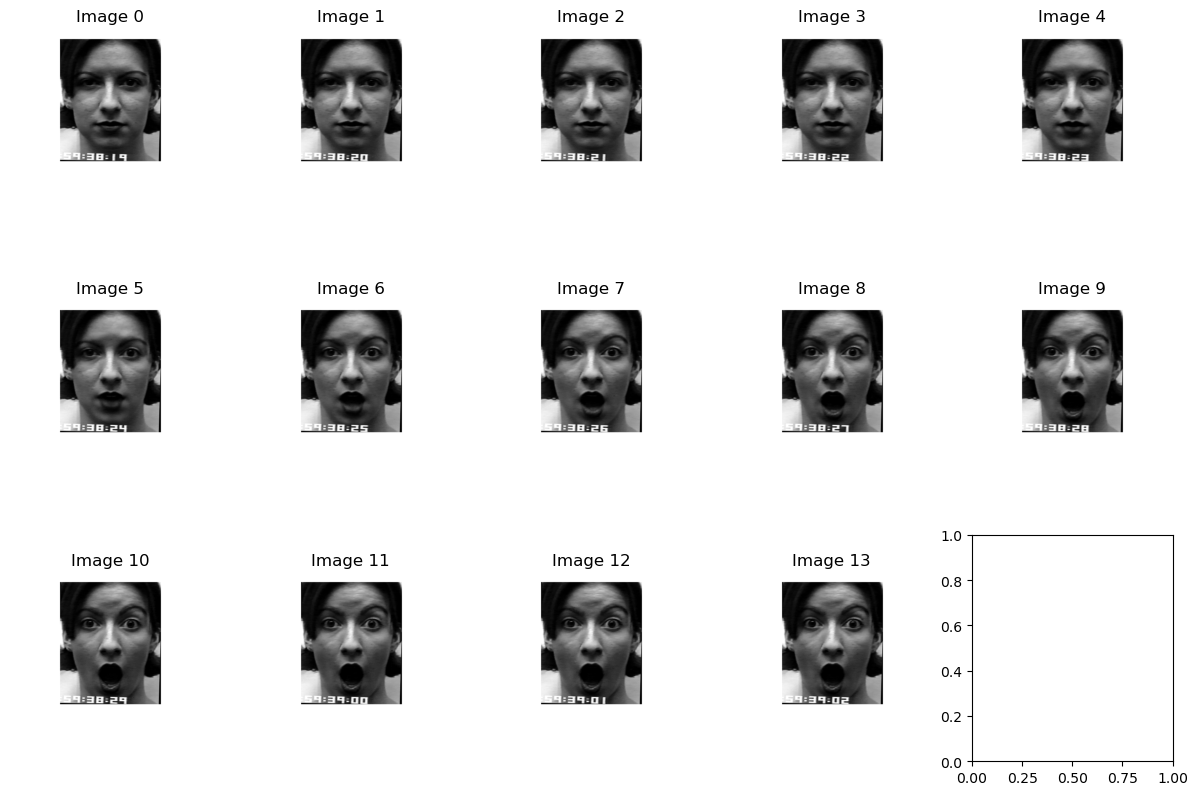

In [3]:
# Plot all images from the first subfolder
size_of_first_sunfolder = len(suprise_images[0])
print(size_of_first_sunfolder)
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
for i in range(3):
    for j in range(5):
        try:
            ax[i, j].imshow(suprise_images[0][i * 5 + j], cmap='gray')
            ax[i, j].axis('off')
            ax[i, j].set_title(f'Image {i * 5 + j}')
        except Exception as e:
            print(e)
plt.show()

In [4]:
def crop_white(gray_image, contours=None):
    if contours is None:
        contours = get_contours(gray_image)
    x, y, w, h = cv.boundingRect(contours[0])
    cropped_image = gray_image[y:y+h, x:x+w]
    return cropped_image
    
    return gray_image


def get_contours(gray_image):
    _, threshold = cv.threshold(gray_image, 254, 255, cv.THRESH_BINARY)
    inverted_threshold = cv.bitwise_not(threshold)
    contours, _ = cv.findContours(inverted_threshold, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    return contours


def fit_size(images):
    min_shape_x = 0
    min_shape_y = 0
    for image in images:
        if image.shape[0] > min_shape_y:
            min_shape_y = image.shape[0]
        if image.shape[1] > min_shape_x:
            min_shape_x = image.shape[1]
    # print(f"Min shape: {min_shape_x}x{min_shape_y}")
    return np.array([cv.resize(img, (min_shape_x, min_shape_y)) for img in images])

def mask_images(images):
    masked_images = []
    for gray in images:
        # Mask the central part of the image
        mask = np.zeros(gray.shape, np.uint8)
        shape = gray.shape
        center = (shape[1] // 2, shape[0] // 2)
        radius_x = math.floor(shape[1] / 2.1)
        radius_y = math.floor(shape[0] / 2.2)

        mask = cv.ellipse(mask, center, (radius_x, radius_y), 0, 0, 360, 255, -1)
        masked_img = cv.bitwise_and(gray, gray, mask=mask)

        masked_images.append(masked_img)
    
    return masked_images

def resize_images(images, size):
    return [cv.resize(img, size) for img in images]

def preprocess_images(images, contours=None):
    # print(images[0].shape)
    cropped_images = [crop_white(img, contours) for img in images]
    # print(cropped_images[0].shape)
    fitted_images = fit_size(cropped_images)
    # print(fitted_images[0].shape)
    masked_images = mask_images(fitted_images)
    half_image_size = (fitted_images[0].shape[1] // 2, fitted_images[0].shape[0] // 2)
    resized_images = resize_images(masked_images, half_image_size)
    # print(resized_images[0].shape)
    return masked_images

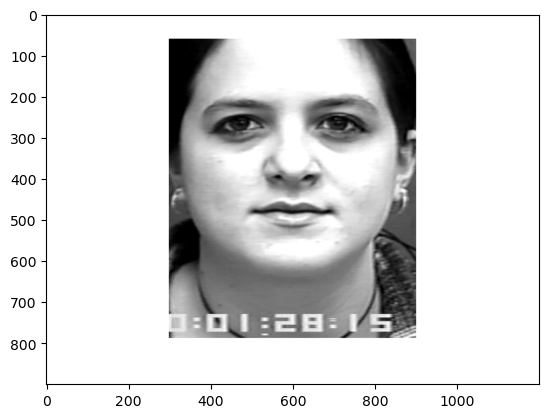

(900, 1200)
(2, 4)


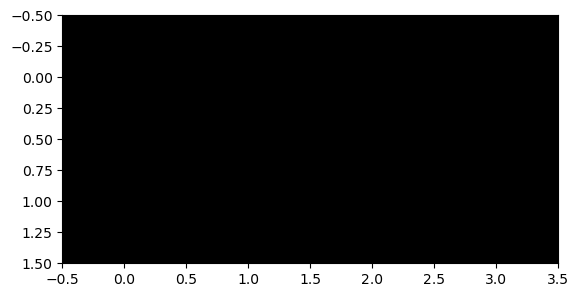

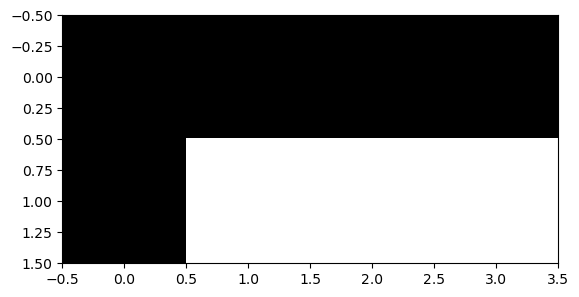

In [5]:
sample_image = suprise_images[-1]
plt.imshow(sample_image[0], cmap='gray')
plt.show()
print(sample_image[0].shape)
cropped_image = crop_white(sample_image[0])
print(cropped_image.shape)
plt.imshow(cropped_image, cmap='gray')
plt.show()
masked_image = mask_images([cropped_image])[0]
plt.imshow(masked_image, cmap='gray')
plt.show()

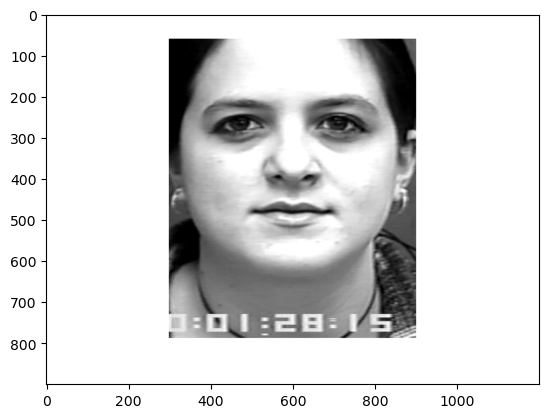

(900, 1200)
(728, 602)


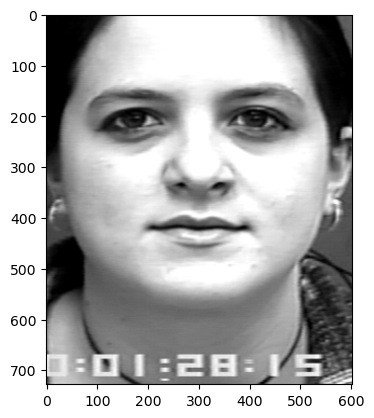

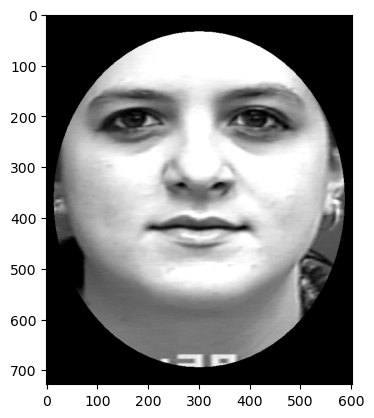

In [6]:
sample_image = suprise_images[-1]
plt.imshow(sample_image[0], cmap='gray')
plt.show()
print(sample_image[0].shape)
countours = get_contours(suprise_images[0][0])
cropped_image = crop_white(sample_image[0], countours)
print(cropped_image.shape)
plt.imshow(cropped_image, cmap='gray')
plt.show()
masked_image = mask_images([cropped_image])[0]
plt.imshow(masked_image, cmap='gray')
plt.show()

In [7]:
countours = get_contours(suprise_images[0][0])
suprise_images_masked = [preprocess_images(subfolder, countours) for subfolder in suprise_images]
happy_images_masked = [preprocess_images(subfolder, countours) for subfolder in happy_images]

14
list index out of range


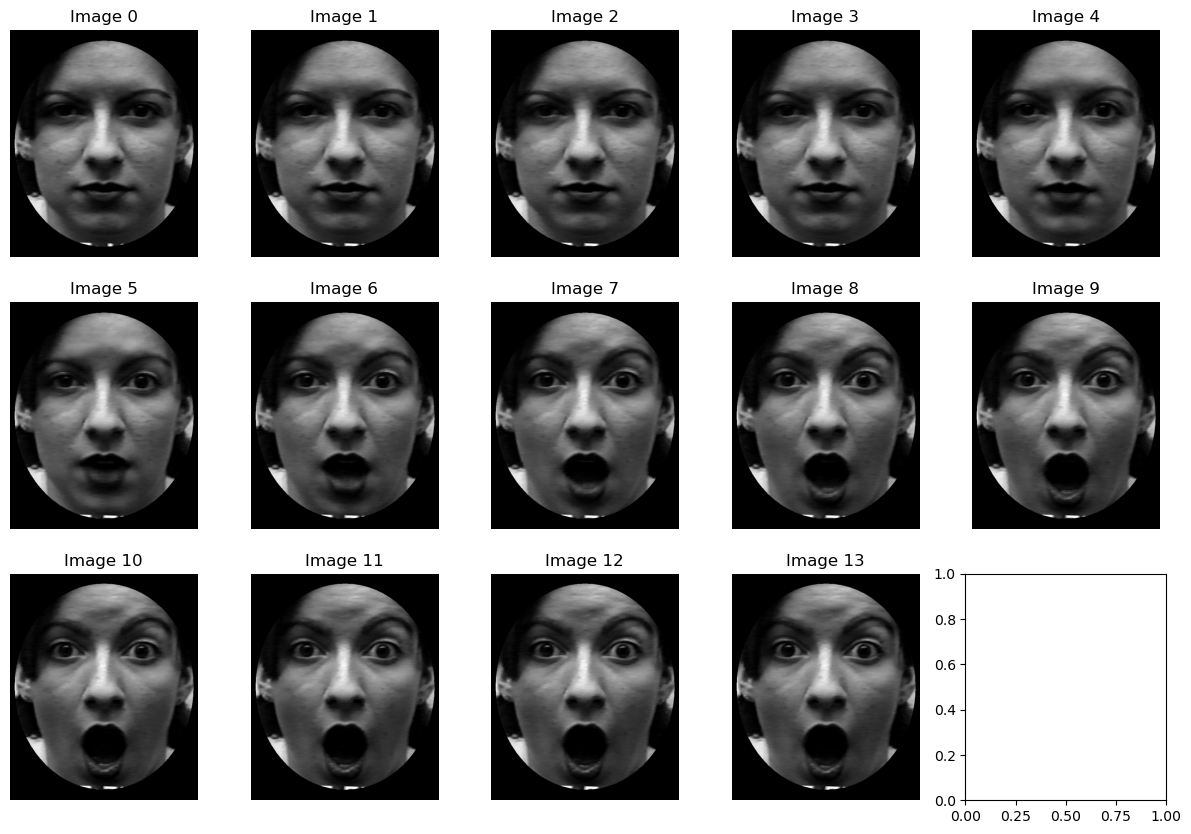

In [8]:
# Plot all images from the first subfolder
size_of_first_sunfolder = len(suprise_images_masked[0])
print(size_of_first_sunfolder)
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
for i in range(3):
    for j in range(5):
        try:
            ax[i, j].imshow(suprise_images_masked[0][i * 5 + j], cmap='gray')
            ax[i, j].axis('off')
            ax[i, j].set_title(f'Image {i * 5 + j}')
        except Exception as e:
            print(e)
plt.show()

In [9]:
def get_optical_flow(images):
    optical_flow = []
    for i in range(1, len(images)):
        flow = cv.calcOpticalFlowFarneback(images[i - 1], images[i], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        optical_flow.append(flow)
    return optical_flow

suprise_optical_flow = [get_optical_flow(subfolder) for subfolder in suprise_images_masked]
happy_optical_flow = [get_optical_flow(subfolder) for subfolder in happy_images_masked]

In [10]:
print(f"Number of optical flow images in the first subfolder: {len(suprise_optical_flow[0])}")

Number of optical flow images in the first subfolder: 13


In [33]:
# Plot histogram of optical flow angles
def get_histogram(optical_flow, bins=8):
    angles = []
    for flow in optical_flow:
        angle = cv.cartToPolar(flow[..., 0], flow[..., 1])[1]
        angle = angle * 180 / np.pi
        # Round the angles to the nearest bin
        angle = np.round(angle / (360 / bins)) * (360 / bins)
        # Get the unique angles
        unique_angles = np.unique(angle)
        # Count the number of identical angles
        sdsd = np.array([np.sum(angle == a) for a in unique_angles])
        angles.append({a: s for a, s in zip(unique_angles, sdsd)})
        
    return angles

suprise_histogram = [get_histogram(subfolder) for subfolder in suprise_optical_flow]
happy_histogram = [get_histogram(subfolder) for subfolder in happy_optical_flow]

In [46]:
def get_histogram_pool_mean(optical_flow, bins=8, is_mean=True):
    return_array = []
    for flow in optical_flow:
        angle = cv.cartToPolar(flow[..., 0], flow[..., 1])[1]
        # Normalize to 0-1
        angle = angle / np.pi / 2
        # Take mean of the angles
        if is_mean:
            angle = np.mean(angle)
        # Take the pool max of the angles
        else:
            angle = np.round(angle / (1 / bins)) * (1 / bins)
            angle = np.array([np.sum(angle == a) for a in np.unique(angle)])
            # angle is the max index of the angle
            angle = np.argmax(angle)/bins
        return_array.append(angle)
    return return_array

suprise_histogram_mean_sample_mean = get_histogram_pool_mean(suprise_optical_flow[0])
suprise_histogram_mean_sample_max = get_histogram_pool_mean(suprise_optical_flow[0], is_mean=False)

print(f"Mean of the first sample: {suprise_histogram_mean_sample_mean}")
print(f"Pooled max of the first sample: {suprise_histogram_mean_sample_max}")

Mean of the first sample: [0.42333788, 0.46372205, 0.49606708, 0.5073188, 0.50371987, 0.49240887, 0.49377066, 0.4960685, 0.49456736, 0.5027554, 0.53051895, 0.50771487, 0.44951612]
Pooled max of the first sample: [0.0, 0.0, 0.0, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.625, 0.75, 0.0, 0.0]


In [ ]:
def get_histogram_pool_and_mean(optical_flow, bins=8):
    pool_optical_flow = get_histogram_pool_mean(optical_flow, bins, is_mean=False)
    mean_optical_flow = get_histogram_pool_mean(optical_flow, bins, is_mean=True)
    return np.concatenate([pool_optical_flow, mean_optical_flow])

suprise_histogram_pool_and_mean = [get_histogram_pool_and_mean(subfolder) for subfolder in suprise_optical_flow]
happy_histogram_pool_and_mean = [get_histogram_pool_and_mean(subfolder) for subfolder in happy_optical_flow]

In [49]:
print(suprise_histogram_pool_and_mean[0])
print(happy_histogram_pool_and_mean[0])

[0.         0.         0.         0.75       0.75       0.75
 0.75       0.75       0.75       0.625      0.75       0.
 0.         0.42333788 0.46372205 0.49606708 0.50731879 0.50371987
 0.49240887 0.49377066 0.49606851 0.49456736 0.5027554  0.53051895
 0.50771487 0.44951612]
[0.5        0.5        0.5        0.75       0.75       0.75
 0.75       0.75       0.75       0.75       0.75       0.
 0.         0.         0.44149166 0.47584352 0.4957971  0.51918775
 0.52379972 0.53512818 0.53100985 0.55222178 0.5412209  0.51994455
 0.51484632 0.47851801 0.51667625 0.46728492]


In [78]:
from scipy.interpolate import interp1d
def pad_vector(vector, desired_length=64):
    vector = np.array(vector)
    current_length = len(vector)
    # Create a range of indices for the original vector
    original_indices = np.arange(current_length)
    # Create new indices for the desired length
    new_indices = np.linspace(0, current_length - 1, desired_length)
    # Interpolate using linear interpolation
    interpolator = interp1d(original_indices, vector, kind='linear', fill_value="extrapolate")
    padded_vector = interpolator(new_indices)
    return padded_vector

sample = [1, 2, 100, 4, 5]
print(f"Sample vector length: {len(sample)}")
padded_sample = pad_vector(sample,8)
print(f"Padded vector length: {len(padded_sample)}")
print(f"Sample vector : {sample}")
print(f"Padded vector : {padded_sample}")

Sample vector length: 5
Padded vector length: 8
Sample vector : [1, 2, 100, 4, 5]
Padded vector : [ 1.          1.57142857 16.         72.         72.57142857 17.71428571
  4.42857143  5.        ]


In [97]:
def pad_vector_with_last_element(vector, desired_length=64):
    vector = np.array(vector)
    current_length = len(vector)
    
    if current_length < desired_length:
        last_element = vector[-1]  # Use the last element for padding
        padding_length = desired_length - current_length
        # Pad with the last element
        padded_vector = np.pad(vector, (0, padding_length), constant_values=last_element)
    else:
        # Truncate if necessary
        padded_vector = vector[:desired_length]
    
    return padded_vector

In [144]:
# pad 
suprise_padd = [pad_vector(v,256) for v in suprise_histogram_pool_and_mean]
happy_padd = [pad_vector(v,256) for v in happy_histogram_pool_and_mean]

In [145]:
train_test_split = 0.7
random.shuffle(suprise_padd)

train_suprise = suprise_padd[:int(len(suprise_padd) * 0.7)]
train_happy = happy_padd[:int(len(happy_padd) * 0.7)]
test_suprise = suprise_padd[int(len(suprise_padd) * 0.7):]
test_happy = happy_padd[int(len(happy_padd) * 0.7):]

In [146]:
print(len(train_happy))
print(len(test_happy))

21
9


In [147]:
train_data = []
train_labels = []
for data in train_suprise:
    train_data.append(data)
    train_labels.append(0)
for data in train_happy:
    train_data.append(data)
    train_labels.append(1)

print(len(train_data))
print(len(train_labels))
print(len(train_data[0]))

42
42
256


In [148]:
test_data = []
test_labels = []
for data in test_suprise:
    test_data.append(data)
    test_labels.append(0)
for data in test_happy:
    test_data.append(data)
    test_labels.append(1)

In [150]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

C = [0.001, 0.01, 0.1, 1, 10, 100]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
max_accuracy = 0
best_c = 0
best_kernel = ''
for c in C:
    for kernel in kernels:
        clf = svm.SVC(C=c, kernel=kernel)
        clf.fit(train_data, train_labels)
        predictions = clf.predict(test_data)
        accuracy = accuracy_score(test_labels, predictions)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_c = c
            best_kernel = kernel
        # print(f"Accuracy for C={c}, kernel={kernel}: {accuracy}")
print(f"Best accuracy: {max_accuracy}")


Best accuracy: 0.7777777777777778
